Import libraries needed

In [28]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import seaborn as sns
from sklearn import linear_model
%matplotlib inline

read the Mexican Peso story

In [21]:
mxn_peso = web.DataReader('DEXMXUS', data_source='fred', start='1/1/2010', end='4/14/2015')

In [40]:
mxn_peso = mxn_peso.reset_index().dropna()

In [41]:
mxn_peso.head()

,DATE,DEXMXUS
0,2010-01-04,12.9110
1,2010-01-05,12.8160
2,2010-01-06,12.7420
3,2010-01-07,12.7590
4,2010-01-08,12.7256


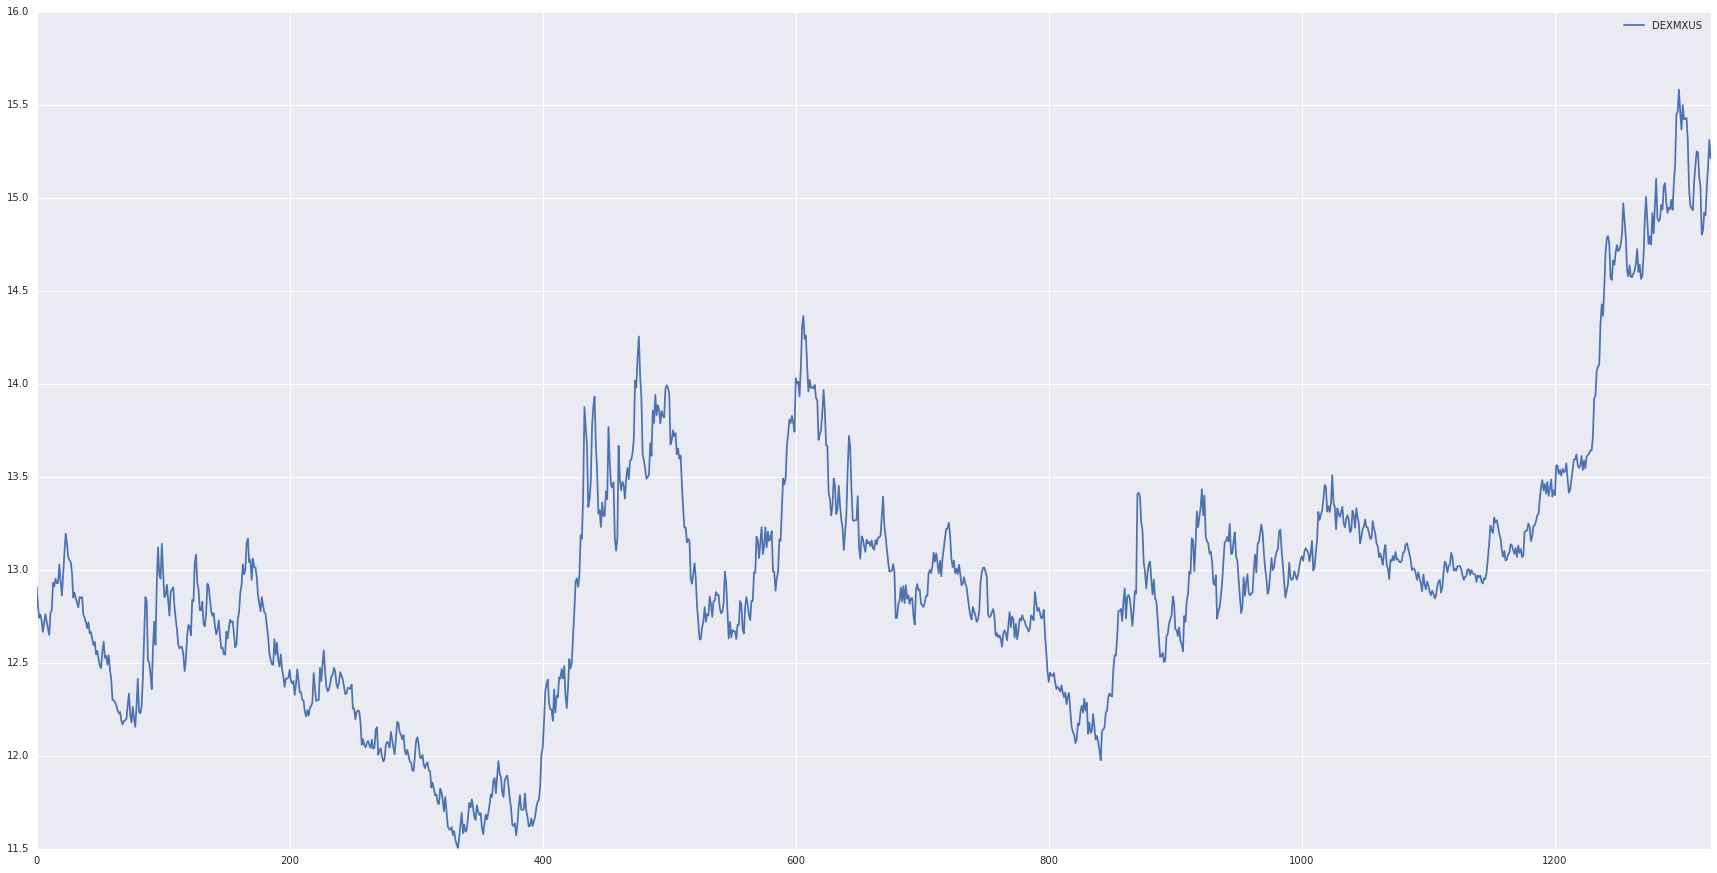

In [42]:
mxn_peso.plot(grid=True, figsize=(30,15))

In [43]:
class ScikitBacktester(object):
    def __init__(self, symbol, start, end, lags):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.lags = lags
        self.get_data()
        self.lm = linear_model.LinearRegression()

    def get_data(self):
        d = web.DataReader(self.symbol, start=self.start, end=self.end, data_source='fed')
        d = pd.DataFrame(d)
        d.columns = ['DEXMXUS']
        d['returns'] = np.log(d / d.shift(1))
        self.data = d.dropna()

    def generate_matrix(self):
        m = np.zeros((self.lags + 1, len(self.data) - self.lags))
        for i in range(self.lags + 1):
            if i == self.lags:
                m[i] = self.data.returns.values[i:]
            else:
                m[i] = self.data.returns.values[i:i - self.lags]
        self.matrix = m

    def fit_model(self):
        self.generate_matrix()
        self.lm.fit(self.matrix[:self.lags].T, self.matrix[self.lags])

    def predict_moves(self):
        self.fit_model()
        pred = self.lm.predict(self.matrix[:self.lags].T)
        return pred

    def run_strategy(self):
        self.data['prediction'] = np.nan
        self.data['prediction'].ix[self.lags:] = self.predict_moves()
        self.data['position'] = np.sign(self.data['prediction'])
        self.data['strategy'] = self.data['position'] * self.data['returns']
        title = '%s | lags = %d' % (self.symbol, self.lags)
        self.data[['returns', 'strategy']].ix[self.lags:].cumsum().apply(np.exp).plot(title=title)